# Data Augmentation

Import the Necessary Libraries

In [3]:
pip install keras 

In [4]:
pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           6.1.0
astropy-iers-data 

In [6]:
pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25855 sha256=4c4f1c6045b53175e4963086f04b8229d116824eed7f706baa1bbbe12dd32a04
  Stored in directory: c:\users\jaina\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time
%matplotlib inline


In [9]:
# Format the time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int((sec_elapsed % (60*60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [10]:
def augmented_data(file_dir, n_generated_samples , save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  brightness_range = (0.3,1.0),
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest'
                                  )
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '\\' + filename)
        image = image.reshape((1,)+ image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1 , save_to_dir=save_to_dir, save_prefix= save_prefix , save_format = 'jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [15]:
import time

# Define paths
yes_path = 'path/to/yes/data'  # Adjust this path
no_path = 'path/to/no/data'     # Adjust this path
augmented_data_path = 'augmented data/'

# Define the augment_data function
def augment_data(file_dir, n_generated_samples, save_to_dir):
    # Your augmentation logic here
    print(f"Augmenting data from {file_dir} with {n_generated_samples} samples, saving to {save_to_dir}")

# Start timing
start_time = time.time()

# Augment data for examples with label 'yes'
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path + 'yes')
# Augment data for examples with label 'no'
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path + 'no')

# End timing
end_time = time.time()
execution_time = (end_time - start_time)

# Function to format the elapsed time
def hms_string(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours)}:{int(minutes):02}:{int(seconds):02}"

# Print elapsed time
print(f"Elapsed time: {hms_string(execution_time)}")


Augmenting data from path/to/yes/data with 6 samples, saving to augmented data/yes
Augmenting data from path/to/no/data with 9 samples, saving to augmented data/no
Elapsed time: 0:00:00


In [16]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 


In [17]:
data_summary(augmented_data_path)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


Brain Tumor Detection using a Convolutional Neural Network

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D , Input , ZeroPadding2D , BatchNormalization , Activation , MaxPooling2D , Flatten , Dense
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.callbacks import TensorBoard , ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
%matplotlib inline

Data PreProcessing

In [19]:
def crop_brain_contour(image, plot=False):
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


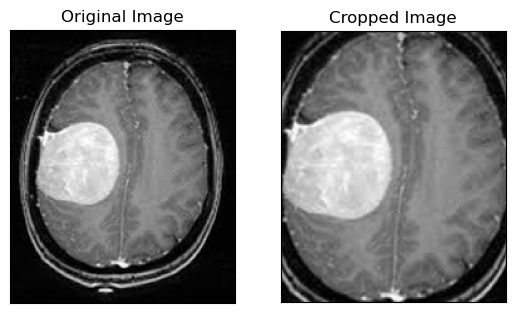

In [20]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img , True)

In [21]:
def load_data(dir_list, image_size):
    
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [22]:
augment_path ="augmented data"
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [23]:
# Plot the images
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


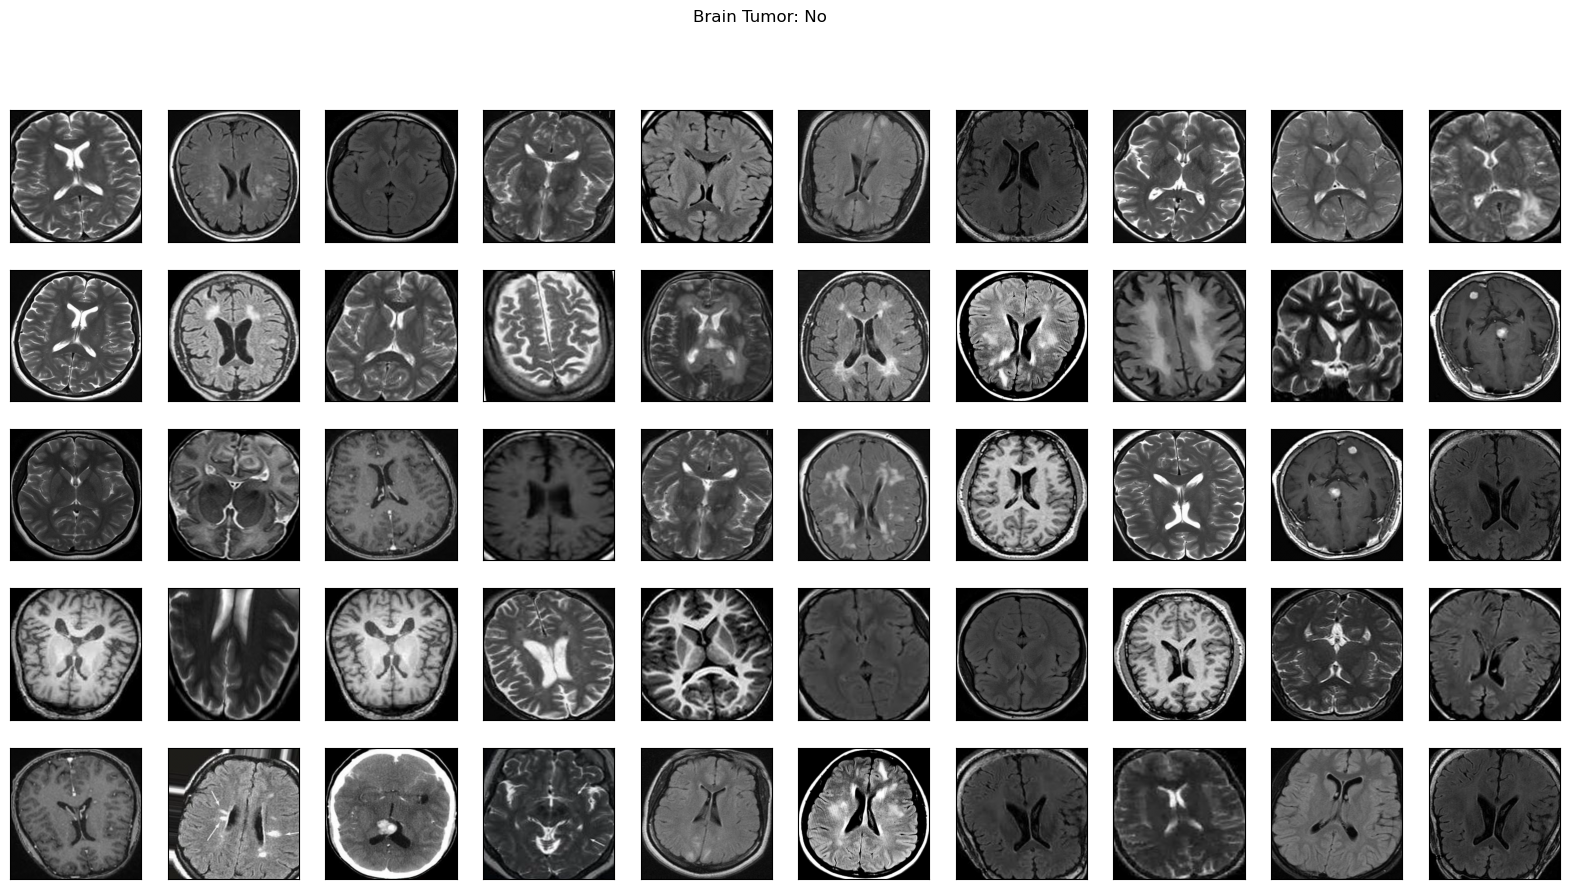

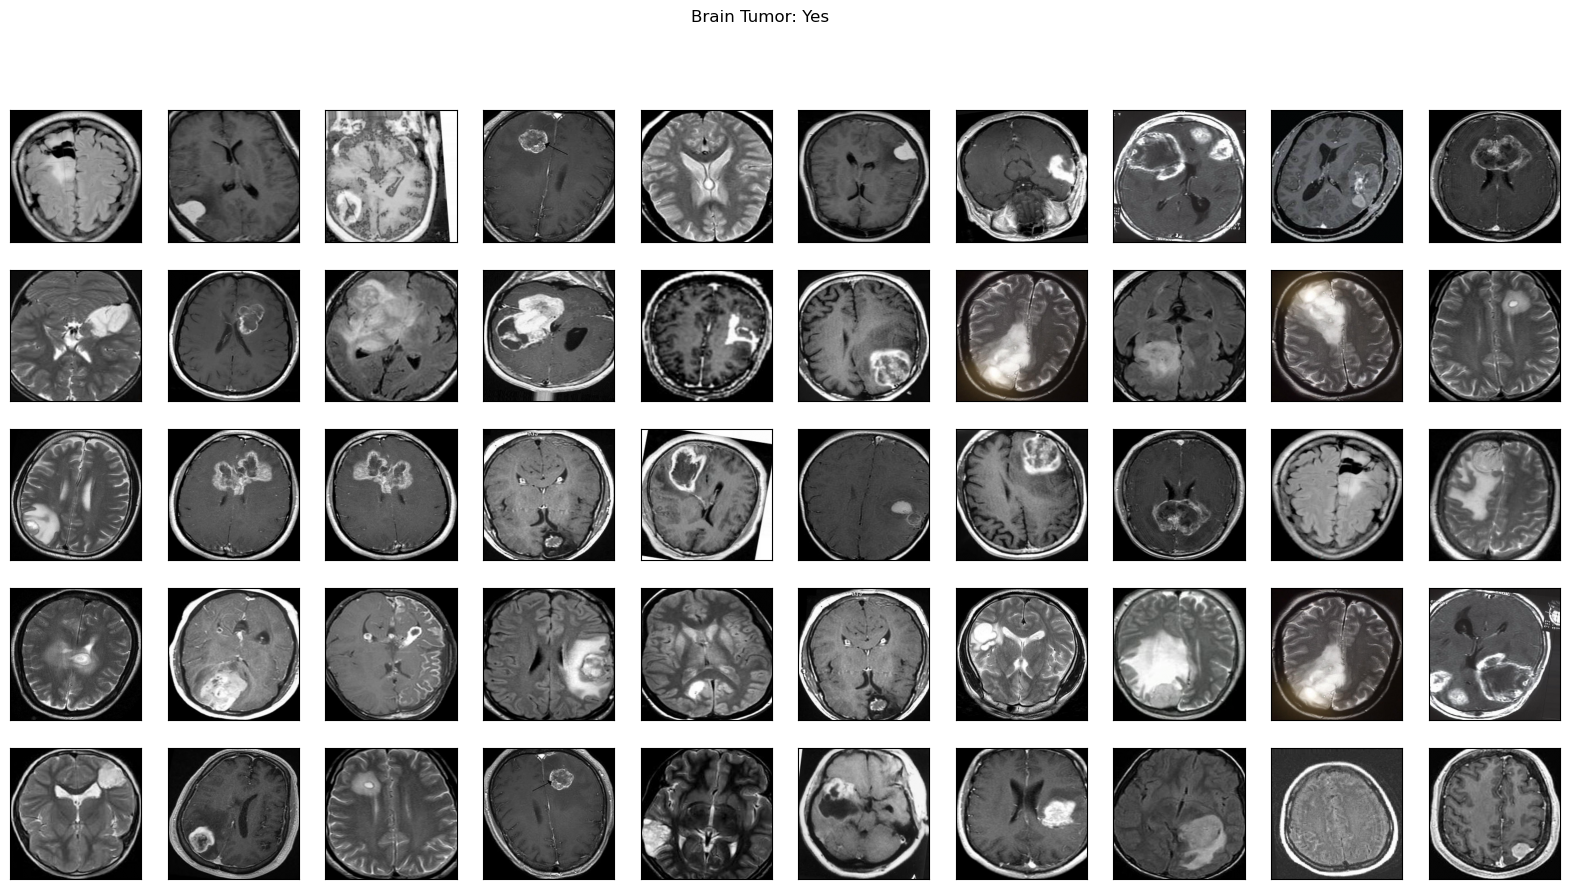

In [24]:
plot_sample_images(X , y)

Split the data
 - Split X and y into training validation and development sets.

In [26]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [27]:
X_train , y_train , X_val , y_val , X_test , y_test = split_data(X, y , test_size=0.7)

In [28]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))


number of training examples = 619
number of development examples = 723
number of test examples = 723
X_train shape: (619, 240, 240, 3)
Y_train shape: (619, 1)
X_val (dev) shape: (723, 240, 240, 3)
Y_val (dev) shape: (723, 1)
X_test shape: (723, 240, 240, 3)
Y_test shape: (723, 1)


In [29]:
# conduct f1 score
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)
    return score


Build the Model

In [30]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    return model

In [33]:
# Define the image shape & find out the summary of model
IMG_SHAPE = (IMG_WIDTH , IMG_HEIGHT , 3)
IMG_SHAPE

(240, 240, 3)

In [34]:
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [35]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


In [38]:
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras"
# Save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


Train the Model

In [42]:
# Correct the filepath to use the right metric name
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Start training
start_time = time.time()
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()

# Calculate execution time
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7861 - loss: 0.4436
Epoch 1: val_accuracy improved from -inf to 0.60996, saving model to models/cnn-parameters-improvement-01-0.61.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step - accuracy: 0.7870 - loss: 0.4427 - val_accuracy: 0.6100 - val_loss: 0.6439
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7998 - loss: 0.4615
Epoch 2: val_accuracy did not improve from 0.60996
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 544ms/step - accuracy: 0.7997 - loss: 0.4608 - val_accuracy: 0.5864 - val_loss: 0.6473
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8433 - loss: 0.3712
Epoch 3: val_accuracy did not improve from 0.60996
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 570ms/step - accuracy: 0.8432 - loss: 0.3709 - val_accuracy: 0.6086 - val_loss: 0.6234
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8916 - loss: 0.3043
Epoch 4: val_accuracy improved from 0.60996 to 0.62241, saving model to models/cnn-

In [43]:
history = model.history.history

In [44]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [47]:
# Plot the accuracy
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


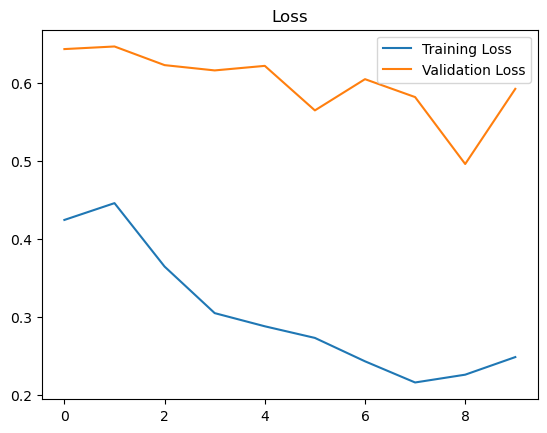

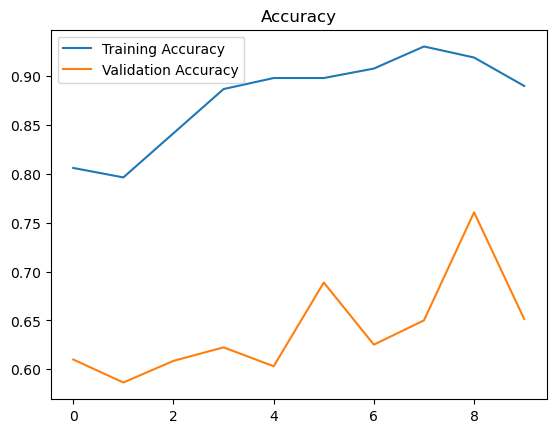

In [48]:
plot_metrics(history)

In [58]:
# Evaluate the model on the test data
loss, acc = model.evaluate(X_test, y_test)

# Print the results
print(f"Test Loss = {loss}")
print(f"Test Accuracy = {acc}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7063 - loss: 0.5751
Test Loss = 0.5824648141860962
Test Accuracy = 0.6832641959190369


In [59]:
y_test_prob = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


In [60]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")


F1 score: 0.6176961602671118


In [61]:
y_val_prob = model.predict(X_val)
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
F1 score: 0.5367647058823529


Result

In [62]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


In [63]:
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [64]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)


Training Data:
Number of examples: 619
Percentage of positive examples: 48.949919224555735%, number of pos examples: 303
Percentage of negative examples: 51.050080775444265%, number of neg examples: 316
Validation Data:
Number of examples: 723
Percentage of positive examples: 51.86721991701245%, number of pos examples: 375
Percentage of negative examples: 48.13278008298755%, number of neg examples: 348
Testing Data:
Number of examples: 723
Percentage of positive examples: 56.293222683264176%, number of pos examples: 407
Percentage of negative examples: 43.706777316735824%, number of neg examples: 316


Conclusion:
- Now, the model detects brain tumor with:
1. 88.7% accuracy on the test set.
2. 0.88 f1 score on the test set.
These resutls are very good considering that the data is balanced.


